In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [4]:
import nltk
import statistics
import numpy as np
import pickle as pkl
from numpy import mean
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional
from tensorflow.keras.models import Sequential, load_model, model_from_config
import tensorflow.keras.backend as K 
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#from textblob import Word
import nltk 
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
X=pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
test=pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv") 

In [6]:
X1_train = X.loc[:int(len(X.index)*0.8)]
y_train = X1_train[['syntax','cohesion','vocabulary','phraseology','grammar','conventions']]
X1_val = X.loc[int(len(X.index)*0.8)+1:int(len(X.index)*0.9)]
y_val = X1_val[['syntax','cohesion','vocabulary','phraseology','grammar','conventions']]
X1_test = X.loc[int(len(X.index)*0.9)+1:]
y_test = X1_test[['syntax','cohesion','vocabulary','phraseology','grammar','conventions']] 

#X1_train is only for extracting out y for each set.

In [7]:
IP=14

y1_train=y_train["syntax"]
y2_train=y_train["cohesion"]
y3_train=y_train["vocabulary"]
y4_train=y_train["phraseology"]
y5_train=y_train["grammar"]
y6_train=y_train["conventions"]

y1_val=y_val["syntax"]
y2_val=y_val["cohesion"]
y3_val=y_val["vocabulary"]
y4_val=y_val["phraseology"]
y5_val=y_val["grammar"]
y6_val=y_val["conventions"]

y1_test=y_test["syntax"]
y2_test=y_test["cohesion"]
y3_test=y_test["vocabulary"]
y4_test=y_test["phraseology"]
y5_test=y_test["grammar"]
y6_test=y_test["conventions"]


y1_train = np.asarray(y1_train)
y1_val = np.asarray(y1_val)  

y2_train = np.asarray(y2_train)
y2_val = np.asarray(y2_val)  

y3_train = np.asarray(y3_train)
y3_val = np.asarray(y3_val)  

y4_train = np.asarray(y4_train)
y4_val = np.asarray(y4_val)  

y5_train = np.asarray(y5_train)
y5_val = np.asarray(y5_val)  

y6_train = np.asarray(y6_train)
y6_val = np.asarray(y6_val)  


In [8]:
def tokenize_sentences(data):
    sent_token = nltk.tokenize.sent_tokenize(data)
    return sent_token, len(sent_token)

def sent_count(data):
    return tokenize_sentences(data)[1]

In [9]:
def tokenize_words(data, punc=False, remove_stop_words=False, lower=True):
    if lower:
        word_tokens = nltk.tokenize.word_tokenize(data.lower())
    else:
        word_tokens = nltk.tokenize.word_tokenize(data)
    if punc:
        word_tokens = [word for word in word_tokens if word.isalnum()]
    if remove_stop_words:
        stop_words = get_stop_words()
        word_tokens = [word for word in word_tokens if word not in stop_words]
        
    return word_tokens, list(set(word_tokens)), len(word_tokens)


def word_count(data):
    return tokenize_words(data)[2]

In [10]:
def sentence_length(sent):
    len_of_sent = []
    for s in sent:
        len_of_sent.append(tokenize_words(s)[2])
    return len_of_sent, statistics.mean(len_of_sent)

def avg_word_sentence(data):
        return sentence_length(tokenize_sentences(data)[0])[1]

In [11]:
def token_length(data):
    words = tokenize_words(data)[0]
    len_of_tokens = {}
    for word in words:
        len_of_tokens[word] = len(word)
    return len_of_tokens
# calls the token_length method and returns the average of token lengths
def avg_length(words):
    return statistics.mean(token_length(words).values())

In [12]:
def pos_tags(data):
    sent = tokenize_sentences(data)[0]
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    adp_count=0
    conj_count = 0
    det_count = 0
    prt_count = 0
    pron_count = 0
    punct_count=0
    
    
    for s in sent:
        tags = nltk.pos_tag(tokenize_words(s)[0])
        #print(tags)
        for tag in tags:
            if tag[1][0] == 'N':
                noun_count += 1
            elif tag[1][0] == 'J':
                adj_count += 1
            elif tag[1][0] == 'V':
                verb_count += 1
            elif tag[1][0] == 'R':
                adv_count += 1
            elif tag[1] == 'IN':
                adp_count += 1
            elif tag[1] == 'CC':
                conj_count += 1
            elif tag[1] == 'DT':
                det_count += 1
            elif tag[1] == 'PRT':
                prt_count += 1
            elif tag[1] == 'PRP' or tag[1] == 'PRP$' :
                pron_count += 1
            elif tag[1] == '.':
                punct_count += 1
                
    return noun_count,adj_count,verb_count,adv_count , adp_count , conj_count, det_count , pron_count , punct_count


pos_tags(" new good on at relly already and or the some year home at on he their his say told ! ")

(3, 2, 1, 2, 4, 2, 2, 3, 1)

In [13]:
X['num_words'] = X['full_text'].apply(word_count)
test['num_words'] = test['full_text'].apply(word_count)
test.head()  


,text_id,full_text,num_words
0,0000C359D63E,when a person has no experience on a job their...,874
1,000BAD50D026,Do you think students would benefit from being...,421
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",484


In [14]:
X['num_sents'] = X['full_text'].apply(sent_count)
test['num_sents'] = test['full_text'].apply(sent_count)
test.head()  

,text_id,full_text,num_words,num_sents
0,0000C359D63E,when a person has no experience on a job their...,874,26
1,000BAD50D026,Do you think students would benefit from being...,421,17
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",484,17


In [15]:
X['num_sents'] = X['full_text'].apply(sent_count)
test['num_sents'] = test['full_text'].apply(sent_count)
test.head()  

,text_id,full_text,num_words,num_sents
0,0000C359D63E,when a person has no experience on a job their...,874,26
1,000BAD50D026,Do you think students would benefit from being...,421,17
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",484,17


In [16]:
X['avg_word_sent'] = X['full_text'].apply(avg_word_sentence)
test['avg_word_sent'] = test['full_text'].apply(avg_word_sentence)
test.head()  

,text_id,full_text,num_words,num_sents,avg_word_sent
0,0000C359D63E,when a person has no experience on a job their...,874,26,33.615385
1,000BAD50D026,Do you think students would benefit from being...,421,17,24.764706
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",484,17,28.470588


In [17]:
X['noun_count'], X['adj_count'], X['verb_count'], X['adv_count'], X['adp_count'],X['conj_count'], X['det_count'], X['pron_count'], X['punct_count']  = zip(*X['full_text'].map(pos_tags))
              
test['noun_count'], test['adj_count'], test['verb_count'], test['adv_count'], test['adp_count'],test['conj_count'], test['det_count'], test['pron_count'], test['punct_count']  = zip(*test['full_text'].map(pos_tags))
                  

In [18]:
X.head()
test.head()

,text_id,full_text,num_words,num_sents,avg_word_sent,noun_count,adj_count,verb_count,adv_count,adp_count,conj_count,det_count,pron_count,punct_count
0,0000C359D63E,when a person has no experience on a job their...,874,26,33.615385,154,40,189,44,90,22,97,111,26
1,000BAD50D026,Do you think students would benefit from being...,421,17,24.764706,88,14,87,18,54,19,19,59,17
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",484,17,28.470588,65,30,107,27,54,14,25,73,17


In [19]:
features = X.iloc[:,8:]
final_test = test.iloc[:,2:]
# print(features.head)
features_array = np.asarray(features)
final_test=np.asarray(final_test)
features_array_train = features_array[:3129]
features_array_val = features_array[3129:3129+391]
features_array_test = features_array[3129+391:]
print(features_array_test.shape)
print(features_array_val.shape)
print(features_array_train.shape)
final_test.shape

print(len(final_test))
final_test

(391, 12)
(391, 12)
(3129, 12)
3


array([[874.        ,  26.        ,  33.61538462, 154.        ,
         40.        , 189.        ,  44.        ,  90.        ,
         22.        ,  97.        , 111.        ,  26.        ],
       [421.        ,  17.        ,  24.76470588,  88.        ,
         14.        ,  87.        ,  18.        ,  54.        ,
         19.        ,  19.        ,  59.        ,  17.        ],
       [484.        ,  17.        ,  28.47058824,  65.        ,
         30.        , 107.        ,  27.        ,  54.        ,
         14.        ,  25.        ,  73.        ,  17.        ]])

In [20]:
lstm_embed_train = []
for i in range(0,len(features_array_train)):
    lstm_embed_train.append(np.asarray([features_array_train[i]]))
    

lstm_embed_test = []
for i in range(0,len(features_array_test)):
    lstm_embed_test.append(np.asarray([features_array_test[i]]))
     


lstm_embed_val = []
for i in range(0,len(features_array_val)):
    lstm_embed_val.append(np.asarray([features_array_val[i]]))
    
lstm_embed_final_test = []
for i in range(0,len(final_test)):
    lstm_embed_final_test.append(np.asarray([final_test[i]]))

lstm_embed_test = np.asarray(lstm_embed_test)
lstm_embed_train = np.asarray(lstm_embed_train)
lstm_embed_val = np.asarray(lstm_embed_val)
lstm_embed_final_test = np.asarray(lstm_embed_final_test)
print(lstm_embed_final_test.shape)
print(lstm_embed_train.shape)
print(lstm_embed_val.shape)
print(lstm_embed_test.shape) 


(3, 1, 12)
(3129, 1, 12)
(391, 1, 12)
(391, 1, 12)


In [21]:
def get_model_lstm():
    
    model = Sequential()
    model.add(LSTM(128, input_shape=[1,12], activation = 'relu',return_sequences=True))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='relu'))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='rmsprop')

    return model 

In [22]:
lstm1 = get_model_lstm();
lstm2 = get_model_lstm();
lstm3 = get_model_lstm();
lstm4 = get_model_lstm();
lstm5 = get_model_lstm();
lstm6 = get_model_lstm();

history1=lstm1.fit(lstm_embed_train, y1_train, epochs=10,validation_data=(lstm_embed_val,y1_val))
history2=lstm2.fit(lstm_embed_train, y2_train, epochs=10,validation_data=(lstm_embed_val,y2_val))
history3=lstm3.fit(lstm_embed_train, y3_train, epochs=10,validation_data=(lstm_embed_val,y3_val))
history4=lstm4.fit(lstm_embed_train, y4_train, epochs=10,validation_data=(lstm_embed_val,y4_val))
history5=lstm5.fit(lstm_embed_train, y5_train, epochs=10,validation_data=(lstm_embed_val,y5_val))
history6=lstm6.fit(lstm_embed_train, y6_train, epochs=10,validation_data=(lstm_embed_val,y6_val))

2022-11-25 09:28:14.816634: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            72192     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 32)             4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              33        
Total params: 76,353
Trainable params: 76,353
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 O

2022-11-25 09:28:15.762124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
98/98 [==============================] - 3s 8ms/step - loss: 2.1939 - val_loss: 0.7042
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1.4347 - val_loss: 0.4565
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1.1666 - val_loss: 0.4362
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.8863 - val_loss: 0.4307
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.7852 - val_loss: 0.4138
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.7014 - val_loss: 0.4345
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.6701 - val_loss: 0.4316
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.6115 - val_loss: 0.4002
Epoch 9/10
98/98 [==============================] - 0s 4ms/step - loss: 0.5980 - val_loss: 0.3977
Epoch 10/10
98/98 [==============================] - 0s 4ms/step - loss: 0.5840 - val_loss: 0.4113
Epoch 1/10
98/98 [=

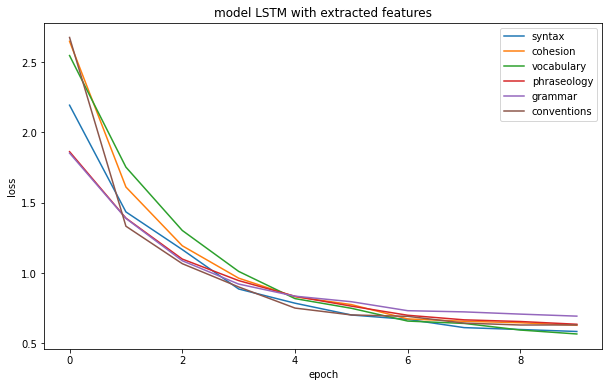

0.3884739949128047


In [35]:

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.plot(history6.history['loss'])

plt.title('model LSTM with extracted features')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['syntax','cohesion','vocabulary','phraseology','grammar','conventions'], loc='upper right')
plt.show()



y1_pred = lstm1.predict(lstm_embed_test).flatten()
y2_pred = lstm2.predict(lstm_embed_test).flatten()
y3_pred = lstm3.predict(lstm_embed_test).flatten()
y4_pred = lstm4.predict(lstm_embed_test).flatten()
y5_pred = lstm5.predict(lstm_embed_test).flatten()
y6_pred = lstm6.predict(lstm_embed_test).flatten()


y1_pred = [round(r,1) for r in y1_pred]
y2_pred = [round(r,1) for r in y2_pred]
y3_pred = [round(r,1) for r in y3_pred]
y4_pred = [round(r,1) for r in y4_pred]
y5_pred = [round(r,1) for r in y5_pred]
y6_pred = [round(r,1) for r in y6_pred]


values1 = mean_squared_error(y1_pred, y1_test)
values2 = mean_squared_error(y2_pred, y2_test)
values3 = mean_squared_error(y3_pred, y3_test)
values4 = mean_squared_error(y4_pred, y4_test)
values5 = mean_squared_error(y5_pred, y5_test)
values6 = mean_squared_error(y6_pred, y6_test)


l=[(values1,values2,values3,values4,values5,values6)]
print(mean(l))

In [24]:
print(lstm_embed_final_test.shape)
lstm_embed_final_test

(3, 1, 12)


array([[[874.        ,  26.        ,  33.61538462, 154.        ,
          40.        , 189.        ,  44.        ,  90.        ,
          22.        ,  97.        , 111.        ,  26.        ]],

       [[421.        ,  17.        ,  24.76470588,  88.        ,
          14.        ,  87.        ,  18.        ,  54.        ,
          19.        ,  19.        ,  59.        ,  17.        ]],

       [[484.        ,  17.        ,  28.47058824,  65.        ,
          30.        , 107.        ,  27.        ,  54.        ,
          14.        ,  25.        ,  73.        ,  17.        ]]])

In [25]:
y1_pred = lstm1.predict(lstm_embed_final_test).flatten()
y2_pred = lstm2.predict(lstm_embed_final_test).flatten()
y3_pred = lstm3.predict(lstm_embed_final_test).flatten()
y4_pred = lstm4.predict(lstm_embed_final_test).flatten()
y5_pred = lstm5.predict(lstm_embed_final_test).flatten()
y6_pred = lstm6.predict(lstm_embed_final_test).flatten()


test1 = [round(r,1) for r in y1_pred]
test2 = [round(r,1) for r in y2_pred]
test3 = [round(r,1) for r in y3_pred]
test4 = [round(r,1) for r in y4_pred]
test5 = [round(r,1) for r in y5_pred]
test6 = [round(r,1) for r in y6_pred]


print(test1)
print(test2)
print(test3)
print(test4)
print(test5)
print(test6)


[3.1, 3.1, 3.1]
[3.1, 3.2, 3.2]
[3.3, 3.3, 3.3]
[3.3, 3.3, 3.3]
[3.1, 3.1, 3.1]
[3.2, 3.2, 3.2]


In [26]:
t1=pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")  

In [27]:
final=pd.DataFrame()

final['text_id']=t1["text_id"]
final['syntax']=test1
final['cohesion']=test2
final['vocabulary']=test3
final['phraseology']=test4
final['grammar']=test5
final['conventions']=test6  

In [26]:
final.to_csv('submission.csv', index=False)

In [27]:
final

,text_id,syntax,cohesion,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.4,3.0,0.0,0.0,0.0,0.0
1,000BAD50D026,3.3,3.2,0.0,0.0,0.0,0.0
2,00367BB2546B,3.2,3.2,0.0,0.0,0.0,0.0
